In [13]:
import sys
sys.path.append('./learn')

from learn_ann import get_learner_params_all
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
K = tf.keras.backend

# If you get error like ModuleNotFoundError: No module named 'tensorflow.keras',
# change line 2 to "K = tf.keras.backend"
# 
# https://www.kaggle.com/c/invasive-species-monitoring/discussion/32762
def AUC(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

DIR = './organized_dataset/'

seed = 7
np.random.seed(seed)

df = pd.read_csv(DIR+'feature_engineered_full.csv',header=0)
df_35 = pd.read_csv(DIR+'sorted_35_full.csv',header=0)

df = df.iloc[:df.shape[0]//2,:]
df_35 = df_35.iloc[:df_35.shape[0]//5,:]

print('Data loading Done')
print(df.describe())

col_max_value = df.iloc[:,4:-1].max()
col_min_value = df.iloc[:,4:-1].min()

df.iloc[:,4:-1] = (df.iloc[:,4:-1] - col_min_value) / (col_max_value - col_min_value)
df.fillna(0, inplace=True)

df_35.iloc[:,4:-1] = (df_35.iloc[:,4:-1] - col_min_value) / (col_max_value - col_min_value)
df_35.fillna(0, inplace=True)

print('Done')

Data loading Done
          Unnamed: 0           CID          DATE    PREV_STATUS  \
count  633396.000000  6.333960e+05  6.333960e+05  633396.000000   
mean   316697.500000  1.439231e+06  1.507173e+09       0.030580   
std    182845.819889  6.290489e+05  2.607603e+07       0.172176   
min         0.000000  1.315130e+05  1.461974e+09       0.000000   
25%    158348.750000  9.251330e+05  1.485821e+09       0.000000   
50%    316697.500000  1.624366e+06  1.506730e+09       0.000000   
75%    475046.250000  1.991490e+06  1.530317e+09       0.000000   
max    633395.000000  2.322343e+06  1.551312e+09       1.000000   

            N_CR_ABM      N_CR_BRCH  N_CR_CHQ       N_CR_EFT    N_CR_MOBILE  \
count  633396.000000  633396.000000  633396.0  633396.000000  633396.000000   
mean        0.232766       0.240624       0.0       1.108892       1.055870   
std         0.947126       0.845800       0.0       2.294814       3.102245   
min         0.000000       0.000000       0.0       0.000000  

### Retrieve Long-term customers' records

In [2]:
SHORT_TERM = 3

print('Term: ',SHORT_TERM)

temp = df.groupby('CID').count()
temp.rename(columns={temp.columns[0]:'length'}, inplace=True)

# get as Series of CID with contract-length less than SHORT_TERM
# temp = temp.loc[temp['length'] >= SHORT_TERM].iloc[:,0]
temp = temp.loc[temp['length'] < SHORT_TERM].iloc[:,0]
print('# of short-term CID: ',temp.shape[0])

short_cid_set = set(temp.index.tolist())

# remove short-term customers
for cid in short_cid_set:
    df.drop(df[df['CID']==cid].index, inplace=True)

long_df = df
print('dataset: ',long_df.shape)
temp = long_df.groupby('CID').count()
temp.rename(columns={temp.columns[0]:'length'}, inplace=True)
temp = temp.loc[temp['length'] >= SHORT_TERM].iloc[:,0]
print('# of long-term CID: ',temp.shape[0])
print('Done')


Term:  3
# of short-term CID:  170
dataset:  (633141, 101)
# of long-term CID:  20429
Done


## Organizing Data
 Separate customers into group of customers with same length of records. Put each group into dictionary.
 So, Returning dict looks like: `dict = {1:group_1_month, 2:group_2_month, ..., 35:group_35_month}`

In [14]:

# get df's dictionary = {length:df,...}
def get_dict_dfs(df,short_term=6):
    dict_of_df = {}
  
    length_df = df.groupby('CID').count()
    length_df.rename(columns={length_df.columns[0]:'length'}, inplace=True)

    # exclude 35-months customers.
    for length in range(short_term,35):
        print('Processing length:',length)
        temp = length_df[length_df['length'] == length]
        short_cid_list = set(temp.index.values)

        current_df = pd.DataFrame(columns=df.columns)
        for cid in short_cid_list:
            temp = df.loc[df['CID']==cid].sort_values(by='DATE')
            current_df = current_df.append(temp, ignore_index=True)

        dict_of_df[length] = current_df
        print('count: ',current_df.shape[0])
    
    # For 35-months customers
    length = 35
    print('For length:',length)
    dict_of_df[length] = df_35
    print('count: ',df_35.shape[0])

    return dict_of_df

dict_dfs = get_dict_dfs(df,short_term = 1)
print('Done')

Processing length: 1
count:  85
Processing length: 2
count:  170
Processing length: 3
count:  297
Processing length: 4
count:  392
Processing length: 5
count:  480
Processing length: 6
count:  552
Processing length: 7
count:  819
Processing length: 8
count:  848
Processing length: 9
count:  774
Processing length: 10
count:  1210
Processing length: 11
count:  1452
Processing length: 12
count:  1620
Processing length: 13
count:  1625
Processing length: 14
count:  1806
Processing length: 15
count:  1695
Processing length: 16
count:  1808
Processing length: 17
count:  2312
Processing length: 18
count:  2520
Processing length: 19
count:  2299
Processing length: 20
count:  2940
Processing length: 21
count:  3318
Processing length: 22
count:  2552
Processing length: 23
count:  3450
Processing length: 24
count:  9072
Processing length: 25
count:  10325
Processing length: 26
count:  11310
Processing length: 27
count:  11394
Processing length: 28
count:  14952
Processing length: 29
count:  15718

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
LW = 1.5 # line width for plots
LL = "lower right" # legend location
LC = 'darkgreen' # Line Color

def get_range_of_customers(df_dict, min_length, max_length):
    M = df_dict[30].shape[1]
    Xy = np.zeros((1,M))
    
    for length in range(min_length,max_length):
        Xy = np.concatenate((Xy, df_dict[length].values), axis=0)
    return Xy[1:,:]

## Logistic

In [ ]:
from sklearn.linear_model import LogisticRegression

# raw_data = dict_dfs[35].iloc[:,3:-1].values
# labels = dict_dfs[35].iloc[:,-1].values

raw_data = df.iloc[:,3:-1].values
labels = df.iloc[:,-1].values

auc_sk_list = []
fn_rate_list = []
fp_rate_list = []
num_of_folds = 10 ## k of k-fold cv ##
for k_index in range(num_of_folds):
    print('================ %d/%d th Learning ================'%(k_index+1,num_of_folds))
    X_train , X_test , y_train , y_test = train_test_split(raw_data , labels , test_size = 0.1,shuffle=True)
    print(y_train)
    M = X_train.shape[1]
    my_class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

    print('class weight:',my_class_weight)

    model = LogisticRegression(random_state=0, solver='lbfgs',class_weight = my_class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    
    tn, fp, fn, tp = confusion_matrix(np.where(y_pred > 0.5, 1, 0), y_test).ravel()
    
    fp_rate = float(fp)/float(fp+tn)
    fn_rate = float(fn)/float(tp+fn)
    fp_rate_list.append(fp_rate)
    fn_rate_list.append(fn_rate)
    print('(TN: %d,FP: %d, FN: %d, TP: %d)'%(tn,fp,fn,tp))
    print('False Positive Rate: %.5f'%(fp_rate))
    print('False Negative Rate: %.5f'%(fn_rate))
    
    fpr, tpr, th = roc_curve(y_test, y_pred)
    auc_sk = auc(fpr, tpr)
    auc_sk_list.append(auc_sk)
    print('AUC: %.5f'%(auc_sk))

    plt.figure()
    plt.title('%d/%d th TEST AUC: %f.5f'%(k_index+1,num_of_folds,auc_sk))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FALSE Positive Rate')
    plt.ylabel('TRUE Positive Rate')
    plt.plot(fpr, tpr, color=LC,lw=LW, label='ROC curve (area = %0.2f)' % auc_sk)
    plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') # reference line for random classifier
    plt.legend(loc=LL)
    plt.show()

print('================ Result ================')
temp = np.mean(auc_sk_list)
print('OVERALL TEST AUC Sk-learn: %.5f (+/- %.4f)'%(temp,np.std(auc_sk_list)))
print('False Positive Rate: %.5f (+/- %.4f)'%(np.mean(fp_rate_list),np.std(fp_rate_list)))
print('False Negative Rate: %.5f (+/- %.4f)'%(np.mean(fn_rate_list),np.std(fn_rate_list)))

## Tree model

================ 1/10 th Learning ================
class weight: {0: 0.518984007922294, 1: 13.668978912319645}
False Positive Rate: 0.01050
False Negative Rate: 0.35904
AUC: 0.78971


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


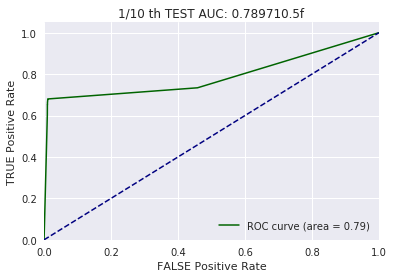

================ 2/10 th Learning ================
class weight: {0: 0.5182196882034883, 1: 14.221420323325635}
False Positive Rate: 0.01547
False Negative Rate: 0.34824
AUC: 0.74142


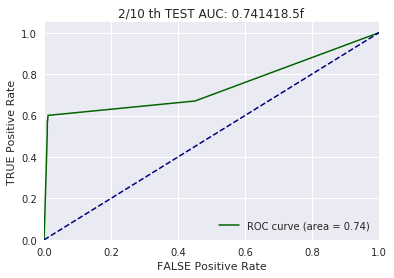

================ 3/10 th Learning ================
class weight: {0: 0.5184160124597479, 1: 14.075142857142858}
False Positive Rate: 0.01139
False Negative Rate: 0.33763
AUC: 0.79067


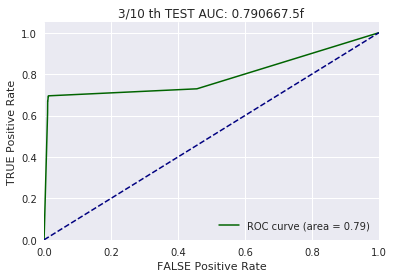

================ 4/10 th Learning ================
class weight: {0: 0.5183069250678619, 1: 14.15603448275862}
False Positive Rate: 0.01154
False Negative Rate: 0.29306
AUC: 0.79168


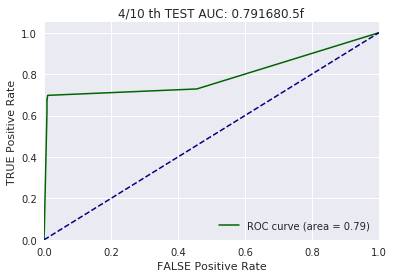

================ 5/10 th Learning ================
class weight: {0: 0.5183069250678619, 1: 14.15603448275862}
False Positive Rate: 0.01223
False Negative Rate: 0.33189
AUC: 0.78220


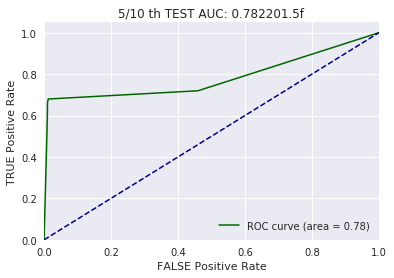

================ 6/10 th Learning ================
class weight: {0: 0.5187107779134903, 1: 13.861283061339336}
False Positive Rate: 0.01087
False Negative Rate: 0.36364
AUC: 0.79317


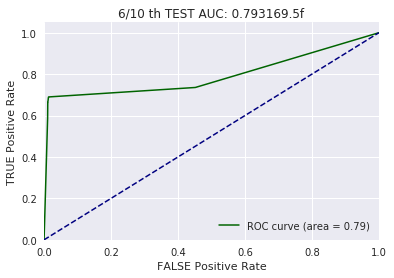

================ 7/10 th Learning ================
class weight: {0: 0.5185469779583588, 1: 13.979284903518728}
False Positive Rate: 0.01203
False Negative Rate: 0.32710
AUC: 0.77648


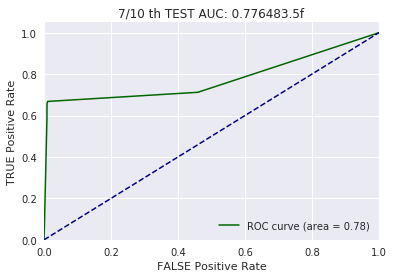

================ 8/10 th Learning ================
class weight: {0: 0.5184269237245327, 1: 14.067104511707596}
False Positive Rate: 0.01162
False Negative Rate: 0.31532
AUC: 0.79849


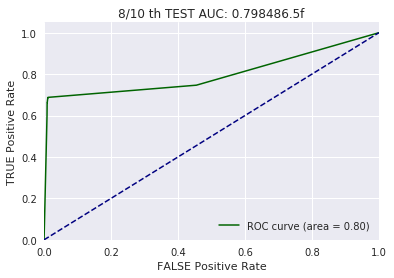

================ 9/10 th Learning ================
class weight: {0: 0.5184924009598788, 1: 14.019066590779738}
False Positive Rate: 0.01235
False Negative Rate: 0.30024
AUC: 0.78030


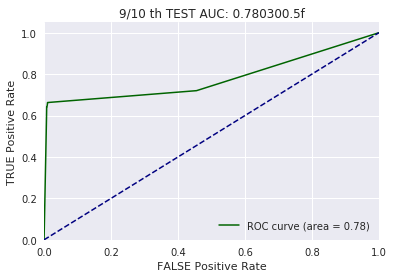

================ 10/10 th Learning ================
class weight: {0: 0.518383281420995, 1: 14.099313108185461}
False Positive Rate: 0.01353
False Negative Rate: 0.31655
AUC: 0.76055


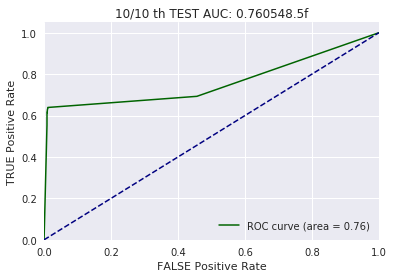

================ Result ================
OVERALL TEST AUC Sk-learn: 0.78047 (+/- 0.0166)
False Positive Rate: 0.01215 (+/- 0.0014)
False Negative Rate: 0.32927 (+/- 0.0224)


In [4]:
from sklearn.tree import DecisionTreeClassifier

raw_data = df.iloc[:,3:-1].values
labels = df.iloc[:,-1].values

auc_list = []
auc_sk_list = []
fn_rate_list = []
fp_rate_list = []
num_of_folds = 10 ## k of k-fold cv ##

for k_index in range(num_of_folds):
    print('================ %d/%d th Learning ================'%(k_index+1,num_of_folds))
    X_train , X_test , y_train , y_test = train_test_split(raw_data , labels , test_size = 0.2,shuffle=True)
    
    temp = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    my_class_weight = {0:temp[0],1:temp[1]}
    print('class weight:',my_class_weight)

    model = DecisionTreeClassifier(class_weight = my_class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    
    tn, fp, fn, tp = confusion_matrix(np.where(y_pred > 0.3, 1, 0), y_test).ravel()
    fp_rate = float(fp)/float(fp+tn)
    fn_rate = float(fn)/float(tp+fn)
    fp_rate_list.append(fp_rate)
    fn_rate_list.append(fn_rate)
    print('False Positive Rate: %.5f'%(fp_rate))
    print('False Negative Rate: %.5f'%(fn_rate))
    
    fpr, tpr, th = roc_curve(y_test, y_pred)
    auc_sk = auc(fpr, tpr)
    auc_sk_list.append(auc_sk)
    print('AUC: %.5f'%(auc_sk))

    plt.figure()
    plt.title('%d/%d th TEST AUC: %f.5f'%(k_index+1,num_of_folds,auc_sk))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FALSE Positive Rate')
    plt.ylabel('TRUE Positive Rate')
    plt.plot(fpr, tpr, color=LC,lw=LW, label='ROC curve (area = %0.2f)' % auc_sk)
    plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') # reference line for random classifier
    plt.legend(loc=LL)
    plt.show()

print('================ Result ================')
temp = np.mean(auc_sk_list)
print('OVERALL TEST AUC Sk-learn: %.5f (+/- %.4f)'%(temp,np.std(auc_sk_list)))
print('False Positive Rate: %.5f (+/- %.4f)'%(np.mean(fp_rate_list),np.std(fp_rate_list)))
print('False Negative Rate: %.5f (+/- %.4f)'%(np.mean(fn_rate_list),np.std(fn_rate_list)))

## SVM

In [ ]:
from sklearn import svm

raw_data = df.iloc[:,3:40].values
labels = df.iloc[:,-1].values

auc_list = []
auc_sk_list = []
fn_rate_list = []
fp_rate_list = []
num_of_folds = 10 ## k of k-fold cv ##

for k_index in range(num_of_folds):
    print('================ %d/%d th Learning ================'%(k_index+1,num_of_folds))
    X_train , X_test , y_train , y_test = train_test_split(raw_data , labels , test_size = 0.2,shuffle=True)
    
    temp = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    my_class_weight = {0:temp[0],1:temp[1]}
    print('class weight:',my_class_weight)

    model = svm.SVC(kernel='linear',class_weight = my_class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    fp_rate = float(fp)/float(fp+tn)
    fn_rate = float(fn)/float(tp+fn)
    fp_rate_list.append(fp_rate)
    fn_rate_list.append(fn_rate)
    print('False Positive Rate: %.5f'%(fp_rate))
    print('False Negative Rate: %.5f'%(fn_rate))
    
    fpr, tpr, th = roc_curve(y_test, y_pred)
    auc_sk = auc(fpr, tpr)
    auc_sk_list.append(auc_sk)
    print('AUC: %.5f'%(auc_sk))

    plt.figure()
    plt.title('%d/%d th TEST AUC: %f.5f'%(k_index+1,num_of_folds,auc_sk))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FALSE Positive Rate')
    plt.ylabel('TRUE Positive Rate')
    plt.plot(fpr, tpr, color=LC,lw=LW, label='ROC curve (area = %0.2f)' % auc_sk)
    plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') # reference line for random classifier
    plt.legend(loc=LL)
    plt.show()

print('================ Result ================')
temp = np.mean(auc_sk_list)
print('OVERALL TEST AUC Sk-learn: %.5f (+/- %.4f)'%(temp,np.std(auc_sk_list)))
print('False Positive Rate: %.5f (+/- %.4f)'%(np.mean(fp_rate_list),np.std(fp_rate_list)))
print('False Negative Rate: %.5f (+/- %.4f)'%(np.mean(fn_rate_list),np.std(fn_rate_list)))

================ 1/10 th Learning ================
class weight: {0: 0.5160243936729675, 1: 16.101214317502702}


## NN

In [ ]:

# raw_data = dict_dfs[35].iloc[:,3:-1].values
# labels = dict_dfs[35].iloc[:,-1].values

raw_data = df.iloc[:,3:-1].values
labels = df.iloc[:,-1].values

auc_list = []
auc_sk_list = []
fn_rate_list = []
fp_rate_list = []
num_of_folds = 5 ## k of k-fold cv ##
for k_index in range(num_of_folds):
    print('================ %d/%d th Learning ================'%(k_index+1,num_of_folds))
    X_train , X_test , y_train , y_test = train_test_split(raw_data , labels , test_size = 0.2,shuffle=True)

    M = X_train.shape[1]
    temp = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    my_class_weight = {0:temp[0],1:temp[1]}
    print('class weight:',my_class_weight)

    model = keras.Sequential()

    model.add(keras.layers.Dense(M, input_dim=M, kernel_initializer='normal', activation='sigmoid'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(M//2, kernel_initializer='normal', activation='relu'))
#     model.add(keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.add(keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[AUC])
    
    model.fit(X_train, y_train, epochs=25, class_weight = my_class_weight)
    train_loss, train_auc = model.evaluate(X_train, y_train)
    test_loss, test_auc = model.evaluate(X_test, y_test)

    print('Test tf AUC: ',test_auc)
    auc_list.append(test_auc)

    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(np.where(y_pred > 0.1, 1, 0), y_test).ravel()
    fp_rate = float(fp)/float(fp+tn)
    fn_rate = float(fn)/float(tp+fn)
    fp_rate_list.append(fp_rate)
    fn_rate_list.append(fn_rate)
    print('(TN: %d,FP: %d, FN: %d, TP: %d)'%(tn,fp,fn,tp))
    print('False Positive Rate: %.5f'%(fp_rate))
    print('False Negative Rate: %.5f'%(fn_rate))
    
    fpr, tpr, th = roc_curve(y_test, y_pred)
    auc_sk = auc(fpr, tpr)
    auc_sk_list.append(auc_sk)
    print('AUC: %.5f'%(auc_sk))

    plt.figure()
    plt.title('%d/%d th TEST AUC'%(k_index+1,num_of_folds))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FALSE Positive Rate')
    plt.ylabel('TRUE Positive Rate')
    plt.plot(fpr, tpr, color=LC,lw=LW, label='ROC curve (area = %0.2f)' % auc_sk)
    plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') # reference line for random classifier
    plt.legend(loc=LL)
    plt.show()

print('================ Result ================')
temp = np.mean(auc_sk_list)
print('OVERALL TEST AUC Sk-learn: %.5f (+/- %.4f)'%(temp,np.std(auc_sk_list)))
print('False Positive Rate: %.5f (+/- %.4f)'%(np.mean(fp_rate_list),np.std(fp_rate_list)))
print('False Negative Rate: %.5f (+/- %.4f)'%(np.mean(fn_rate_list),np.std(fn_rate_list)))

# Background

In [ ]:
!python3 -u nn_test.py >> ./nn_20Percent_of_full.out

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2019-04-10 08:35:03.966907: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA


# Termwise Classification

## Logistic

Xy shape: (1424, 101)
====== [1 to 6) ====== 1/5 th Learning ================
class weight: [ 0.51778496 14.55681818]
(TN: 138,FP: 0, FN: 0, TP: 5)
False Positive Rate: 0.00000
False Negative Rate: 0.00000
AUC: 1.00000


/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:637: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


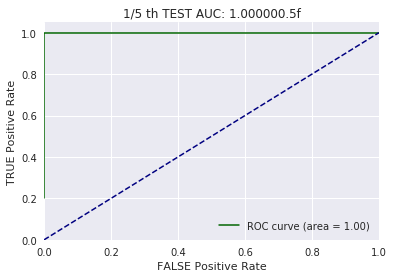

====== [1 to 6) ====== 2/5 th Learning ================
class weight: [ 0.51862348 13.92391304]
(TN: 138,FP: 1, FN: 2, TP: 2)
False Positive Rate: 0.00719
False Negative Rate: 0.50000
AUC: 0.96429


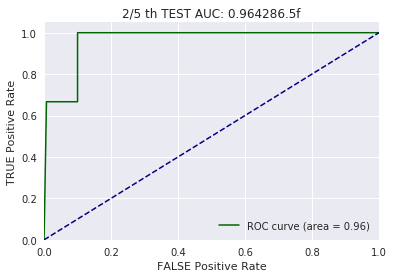

====== [1 to 6) ====== 3/5 th Learning ================
class weight: [ 0.51862348 13.92391304]
(TN: 140,FP: 0, FN: 0, TP: 3)
False Positive Rate: 0.00000
False Negative Rate: 0.00000
AUC: 1.00000


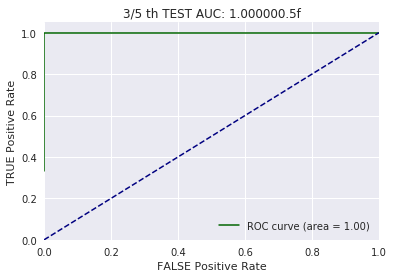

====== [1 to 6) ====== 4/5 th Learning ================
class weight: [ 0.51653226 15.62195122]
(TN: 132,FP: 3, FN: 3, TP: 5)
False Positive Rate: 0.02222
False Negative Rate: 0.37500
AUC: 0.87731


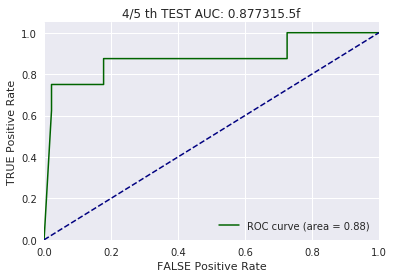

====== [1 to 6) ====== 5/5 th Learning ================
class weight: [ 0.51778496 14.55681818]
(TN: 138,FP: 0, FN: 0, TP: 5)
False Positive Rate: 0.00000
False Negative Rate: 0.00000
AUC: 1.00000


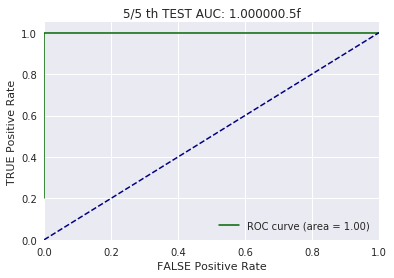

====== [1 to 6) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.96832 (+/- 0.0476)
False Positive Rate: 0.00588 (+/- 0.0086)
False Negative Rate: 0.17500 (+/- 0.2179)
Xy shape: (4203, 101)
====== [6 to 11) ====== 1/5 th Learning ================
class weight: [0.52777003 9.50251256]
(TN: 383,FP: 2, FN: 5, TP: 31)
False Positive Rate: 0.00519
False Negative Rate: 0.13889
AUC: 0.95884


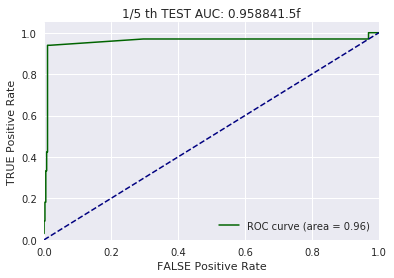

====== [6 to 11) ====== 2/5 th Learning ================
class weight: [0.52909905 9.09134615]
(TN: 393,FP: 6, FN: 4, TP: 18)
False Positive Rate: 0.01504
False Negative Rate: 0.18182
AUC: 0.91063


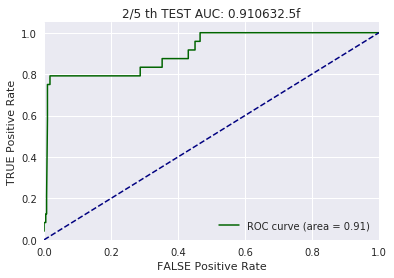

====== [6 to 11) ====== 3/5 th Learning ================
class weight: [0.5293953 9.0047619]
(TN: 394,FP: 3, FN: 5, TP: 19)
False Positive Rate: 0.00756
False Negative Rate: 0.20833
AUC: 0.92384


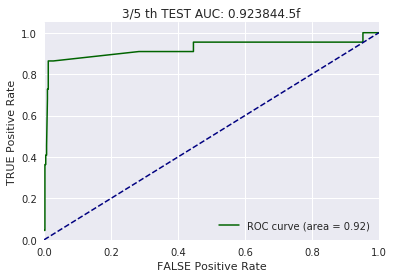

====== [6 to 11) ====== 4/5 th Learning ================
class weight: [0.52835988 9.31527094]
(TN: 389,FP: 4, FN: 3, TP: 25)
False Positive Rate: 0.01018
False Negative Rate: 0.10714
AUC: 0.94247


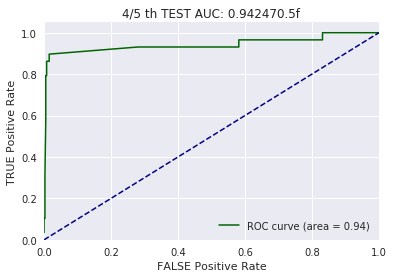

====== [6 to 11) ====== 5/5 th Learning ================
class weight: [0.52969188 8.91981132]
(TN: 395,FP: 3, FN: 6, TP: 17)
False Positive Rate: 0.00754
False Negative Rate: 0.26087
AUC: 0.93248


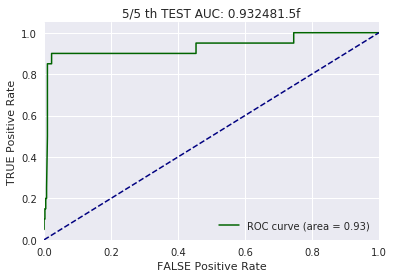

====== [6 to 11) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.93365 (+/- 0.0164)
False Positive Rate: 0.00910 (+/- 0.0034)
False Negative Rate: 0.17941 (+/- 0.0536)
Xy shape: (8198, 101)
====== [11 to 16) ====== 1/5 th Learning ================
class weight: [0.5498584 5.5142003]
(TN: 736,FP: 9, FN: 17, TP: 58)
False Positive Rate: 0.01208
False Negative Rate: 0.22667
AUC: 0.96443


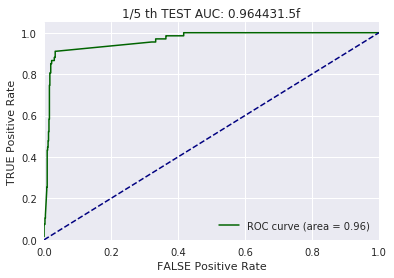

====== [11 to 16) ====== 2/5 th Learning ================
class weight: [0.54928529 5.57250755]
(TN: 735,FP: 12, FN: 11, TP: 62)
False Positive Rate: 0.01606
False Negative Rate: 0.15068
AUC: 0.95370


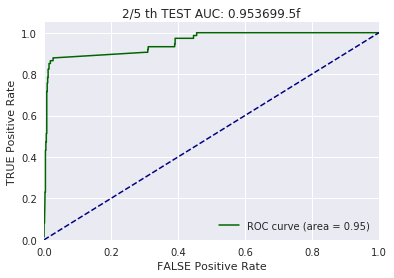

====== [11 to 16) ====== 3/5 th Learning ================
class weight: [0.54830559 5.67538462]
(TN: 724,FP: 9, FN: 10, TP: 77)
False Positive Rate: 0.01228
False Negative Rate: 0.11494
AUC: 0.96861


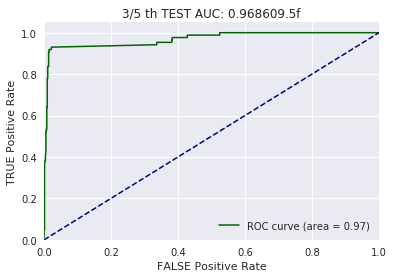

====== [11 to 16) ====== 4/5 th Learning ================
class weight: [0.54969453 5.53073463]
(TN: 740,FP: 17, FN: 11, TP: 52)
False Positive Rate: 0.02246
False Negative Rate: 0.17460
AUC: 0.91079


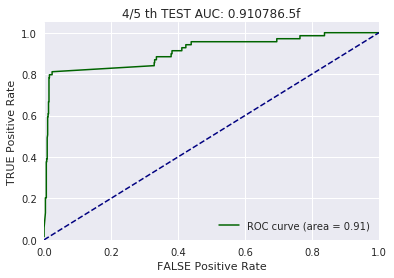

====== [11 to 16) ====== 5/5 th Learning ================
class weight: [0.548795   5.62347561]
(TN: 726,FP: 7, FN: 14, TP: 73)
False Positive Rate: 0.00955
False Negative Rate: 0.16092
AUC: 0.94864


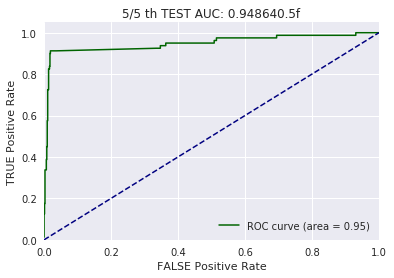

====== [11 to 16) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.94923 (+/- 0.0205)
False Positive Rate: 0.01449 (+/- 0.0045)
False Negative Rate: 0.16556 (+/- 0.0364)
Xy shape: (11879, 101)
====== [16 to 21) ====== 1/5 th Learning ================
class weight: [0.54274546 6.34857482]
(TN: 1072,FP: 17, FN: 22, TP: 77)
False Positive Rate: 0.01561
False Negative Rate: 0.22222
AUC: 0.91845


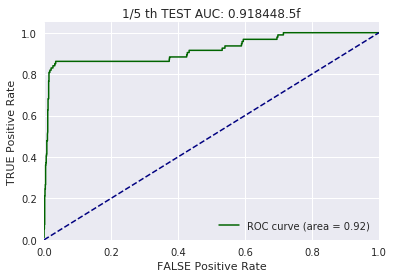

====== [16 to 21) ====== 2/5 th Learning ================
class weight: [0.54313148 6.29623086]
(TN: 1080,FP: 16, FN: 21, TP: 71)
False Positive Rate: 0.01460
False Negative Rate: 0.22826
AUC: 0.94298


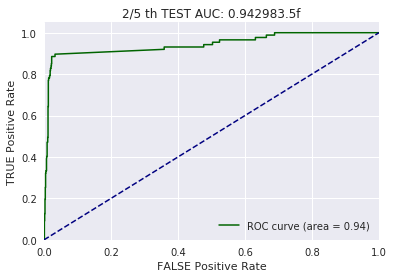

====== [16 to 21) ====== 3/5 th Learning ================
class weight: [0.54252512 6.37887828]
(TN: 1068,FP: 14, FN: 22, TP: 84)
False Positive Rate: 0.01294
False Negative Rate: 0.20755
AUC: 0.92958


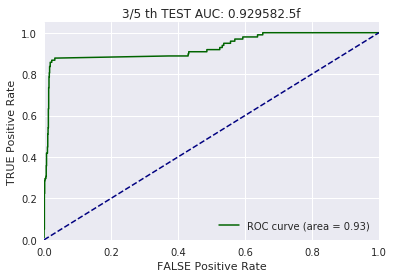

====== [16 to 21) ====== 4/5 th Learning ================
class weight: [0.54285569 6.33353081]
(TN: 1075,FP: 20, FN: 21, TP: 72)
False Positive Rate: 0.01826
False Negative Rate: 0.22581
AUC: 0.90565


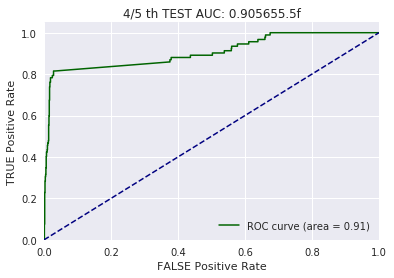

====== [16 to 21) ====== 5/5 th Learning ================
class weight: [0.54263527 6.36369048]
(TN: 1079,FP: 10, FN: 13, TP: 86)
False Positive Rate: 0.00918
False Negative Rate: 0.13131
AUC: 0.95306


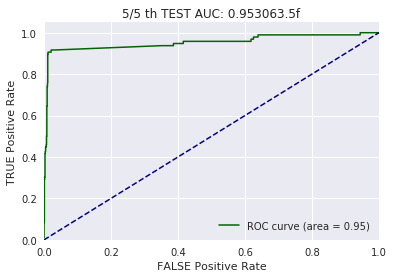

====== [16 to 21) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.92995 (+/- 0.0169)
False Positive Rate: 0.01412 (+/- 0.0030)
False Negative Rate: 0.20303 (+/- 0.0366)
Xy shape: (28717, 101)
====== [21 to 26) ====== 1/5 th Learning ================
class weight: [ 0.51727244 14.97392816]
(TN: 2741,FP: 32, FN: 26, TP: 73)
False Positive Rate: 0.01154
False Negative Rate: 0.26263
AUC: 0.86260


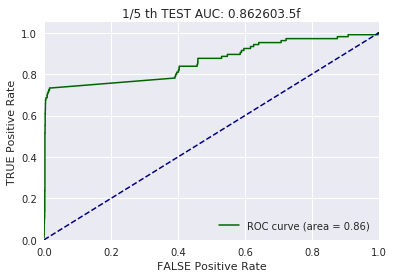

====== [21 to 26) ====== 2/5 th Learning ================
class weight: [ 0.51756248 14.73489168]
(TN: 2762,FP: 31, FN: 19, TP: 60)
False Positive Rate: 0.01110
False Negative Rate: 0.24051
AUC: 0.86725


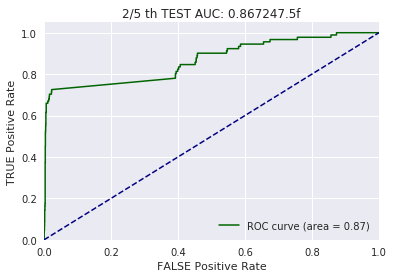

====== [21 to 26) ====== 3/5 th Learning ================
class weight: [ 0.51712754 15.0963785 ]
(TN: 2737,FP: 29, FN: 23, TP: 83)
False Positive Rate: 0.01048
False Negative Rate: 0.21698
AUC: 0.89997


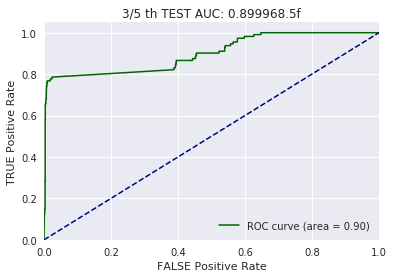

====== [21 to 26) ====== 4/5 th Learning ================
class weight: [ 0.51737599 14.88767281]
(TN: 2750,FP: 25, FN: 22, TP: 75)
False Positive Rate: 0.00901
False Negative Rate: 0.22680
AUC: 0.90721


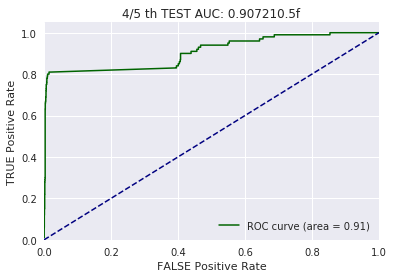

====== [21 to 26) ====== 5/5 th Learning ================
class weight: [ 0.51735527 14.90484429]
(TN: 2742,FP: 30, FN: 29, TP: 71)
False Positive Rate: 0.01082
False Negative Rate: 0.29000
AUC: 0.90012


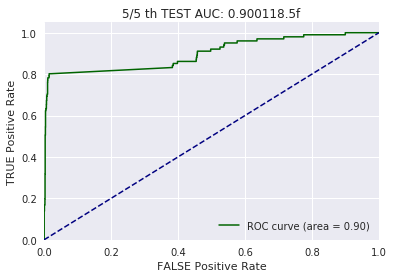

====== [21 to 26) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.88743 (+/- 0.0186)
False Positive Rate: 0.01059 (+/- 0.0009)
False Negative Rate: 0.24738 (+/- 0.0262)
Xy shape: (64654, 101)
====== [26 to 31) ====== 1/5 th Learning ================
class weight: [ 0.51491071 17.26646884]
(TN: 6235,FP: 49, FN: 43, TP: 139)
False Positive Rate: 0.00780
False Negative Rate: 0.23626
AUC: 0.89254


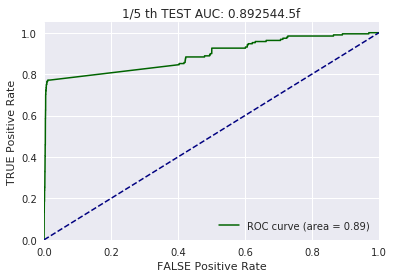

====== [26 to 31) ====== 2/5 th Learning ================
class weight: [ 0.51491983 17.25622776]
(TN: 6219,FP: 62, FN: 60, TP: 125)
False Positive Rate: 0.00987
False Negative Rate: 0.32432
AUC: 0.84137


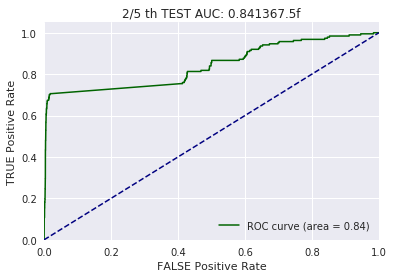

====== [26 to 31) ====== 3/5 th Learning ================
class weight: [ 0.51501098 17.15448113]
(TN: 6237,FP: 52, FN: 52, TP: 125)
False Positive Rate: 0.00827
False Negative Rate: 0.29379
AUC: 0.88353


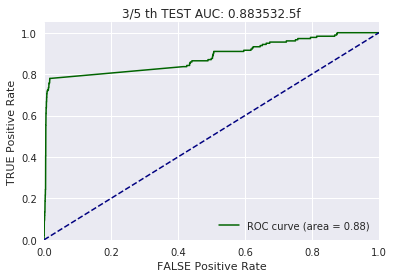

====== [26 to 31) ====== 4/5 th Learning ================
class weight: [ 0.51498363 17.18487891]
(TN: 6235,FP: 49, FN: 51, TP: 131)
False Positive Rate: 0.00780
False Negative Rate: 0.28022
AUC: 0.88303


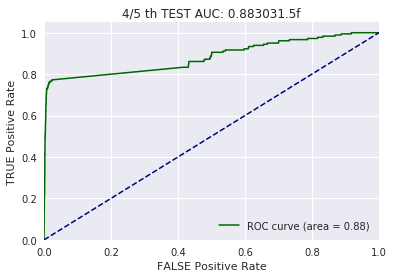

====== [26 to 31) ====== 5/5 th Learning ================
class weight: [ 0.51487426 17.30755503]
(TN: 6229,FP: 53, FN: 45, TP: 139)
False Positive Rate: 0.00844
False Negative Rate: 0.24457
AUC: 0.88762


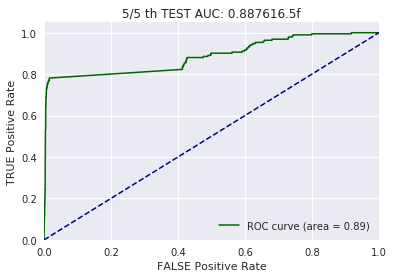

====== [26 to 31) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.87762 (+/- 0.0184)
False Positive Rate: 0.00843 (+/- 0.0008)
False Negative Rate: 0.27583 (+/- 0.0324)
Xy shape: (233880, 101)
====== [31 to 36) ====== 1/5 th Learning ================
class weight: [ 0.51693042 15.26631854]
(TN: 22416,FP: 232, FN: 197, TP: 543)
False Positive Rate: 0.01024
False Negative Rate: 0.26622
AUC: 0.88645


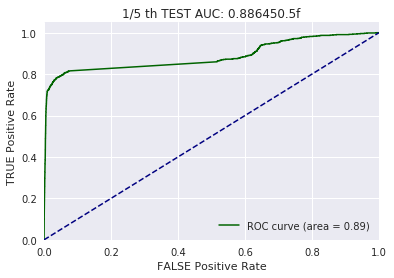

====== [31 to 36) ====== 2/5 th Learning ================
class weight: [ 0.51691011 15.2840546 ]
(TN: 22421,FP: 227, FN: 184, TP: 556)
False Positive Rate: 0.01002
False Negative Rate: 0.24865
AUC: 0.87245


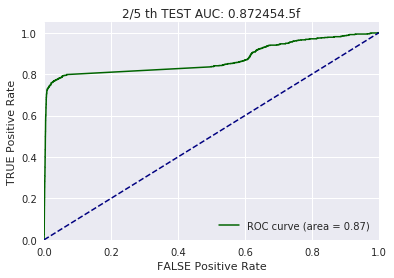

====== [31 to 36) ====== 3/5 th Learning ================
class weight: [ 0.51683903 15.34645669]
(TN: 22389,FP: 242, FN: 188, TP: 569)
False Positive Rate: 0.01069
False Negative Rate: 0.24835
AUC: 0.88739


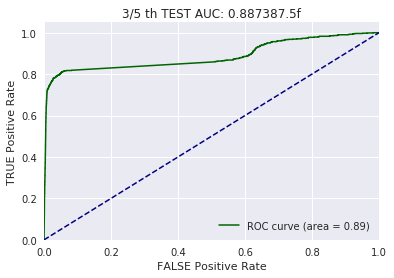

====== [31 to 36) ====== 4/5 th Learning ================
class weight: [ 0.51684665 15.33974639]
(TN: 22379,FP: 232, FN: 201, TP: 576)
False Positive Rate: 0.01026
False Negative Rate: 0.25869
AUC: 0.88502


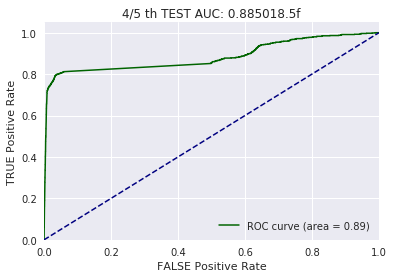

====== [31 to 36) ====== 5/5 th Learning ================
class weight: [ 0.5169939  15.21115768]
(TN: 22464,FP: 205, FN: 174, TP: 545)
False Positive Rate: 0.00904
False Negative Rate: 0.24200
AUC: 0.88973


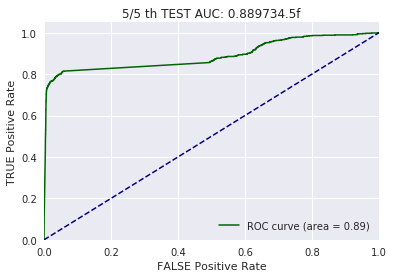

====== [31 to 36) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.88421 (+/- 0.0061)
False Positive Rate: 0.01005 (+/- 0.0005)
False Negative Rate: 0.25278 (+/- 0.0086)


In [23]:
from sklearn.linear_model import LogisticRegression


length_interval = 5
for start in range(1,36,length_interval):
    Xy = get_range_of_customers(dict_dfs, start, start+length_interval)
    print('Xy shape:',Xy.shape)
    raw_data = Xy[:,3:-1]
    labels = Xy[:,-1]
    
    auc_sk_list = []
    fn_rate_list = []
    fp_rate_list = []
    num_of_folds = 5 ## k of k-fold cv ##
    for k_index in range(num_of_folds):
        print('====== [%d to %d) ====== %d/%d th Learning ================'%(start,start+length_interval,k_index+1,num_of_folds))
        X_train , X_test , y_train , y_test = train_test_split(raw_data , labels , test_size = 0.1,shuffle=True)
        
        y_train =y_train.astype('int')
        y_test = y_test.astype('int')

        M = X_train.shape[1]
        my_class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

        print('class weight:',my_class_weight)

        model = LogisticRegression(random_state=0, solver='lbfgs',class_weight = my_class_weight)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:,1]

        tn, fp, fn, tp = confusion_matrix(np.where(y_pred > 0.5, 1, 0), y_test).ravel()

        fp_rate = float(fp)/float(fp+tn)
        fn_rate = float(fn)/float(tp+fn)
        fp_rate_list.append(fp_rate)
        fn_rate_list.append(fn_rate)
        print('(TN: %d,FP: %d, FN: %d, TP: %d)'%(tn,fp,fn,tp))
        print('False Positive Rate: %.5f'%(fp_rate))
        print('False Negative Rate: %.5f'%(fn_rate))

        fpr, tpr, th = roc_curve(y_test, y_pred)
        auc_sk = auc(fpr, tpr)
        auc_sk_list.append(auc_sk)
        print('AUC: %.5f'%(auc_sk))

        plt.figure()
        plt.title('%d/%d th TEST AUC: %f.5f'%(k_index+1,num_of_folds,auc_sk))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('FALSE Positive Rate')
        plt.ylabel('TRUE Positive Rate')
        plt.plot(fpr, tpr, color=LC,lw=LW, label='ROC curve (area = %0.2f)' % auc_sk)
        plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') # reference line for random classifier
        plt.legend(loc=LL)
        plt.show()

    print('====== [%d to %d) ========== Result ================'%(start,start+length_interval))
    temp = np.mean(auc_sk_list)
    print('OVERALL TEST AUC Sk-learn: %.5f (+/- %.4f)'%(temp,np.std(auc_sk_list)))
    print('False Positive Rate: %.5f (+/- %.4f)'%(np.mean(fp_rate_list),np.std(fp_rate_list)))
    print('False Negative Rate: %.5f (+/- %.4f)'%(np.mean(fn_rate_list),np.std(fn_rate_list)))
    


## ANN

Xy shape: (1424, 101)
====== [1 to 6) ====== 1/5 th Learning ================
class weight: [ 0.51820388 14.23333333]
143/143 [==============================] - 0s 127us/step
Test tf AUC:  0.911225952468552
(TN: 138,FP: 2, FN: 1, TP: 2)
False Positive Rate: 0.01429
False Negative Rate: 0.33332
AUC: 0.74820


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


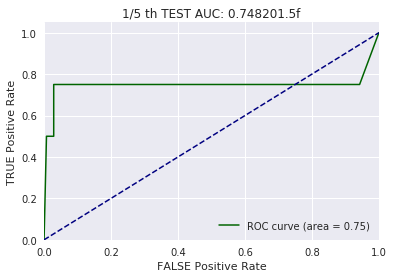

====== [1 to 6) ====== 2/5 th Learning ================
class weight: [ 0.51904376 13.62765957]
143/143 [==============================] - 0s 96us/step
Test tf AUC:  0.8816398498895285
(TN: 139,FP: 0, FN: 2, TP: 2)
False Positive Rate: 0.00000
False Negative Rate: 0.49999
AUC: 0.99291


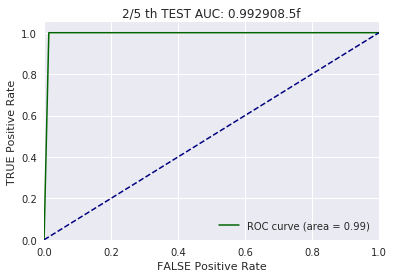

====== [1 to 6) ====== 3/5 th Learning ================
class weight: [ 0.51653226 15.62195122]
143/143 [==============================] - 0s 130us/step
Test tf AUC:  0.8679210060126298
(TN: 132,FP: 0, FN: 3, TP: 8)
False Positive Rate: 0.00000
False Negative Rate: 0.27272
AUC: 1.00000


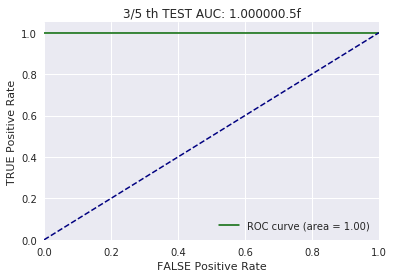

====== [1 to 6) ====== 4/5 th Learning ================
class weight: [ 0.51946472 13.34375   ]
143/143 [==============================] - 0s 187us/step
Test tf AUC:  0.8750399334447367
(TN: 141,FP: 0, FN: 1, TP: 1)
False Positive Rate: 0.00000
False Negative Rate: 0.49998
AUC: 0.99648


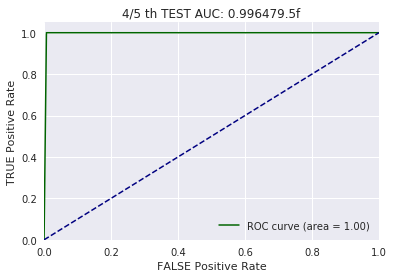

====== [1 to 6) ====== 5/5 th Learning ================
class weight: [ 0.51778496 14.55681818]
143/143 [==============================] - 0s 125us/step
Test tf AUC:  0.8892244963379173
(TN: 137,FP: 1, FN: 1, TP: 4)
False Positive Rate: 0.00725
False Negative Rate: 0.20000
AUC: 0.88551


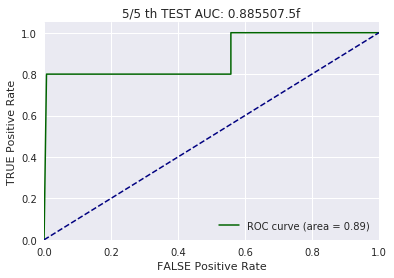

====== [1 to 6) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.92462 (+/- 0.0981)
False Positive Rate: 0.00431 (+/- 0.0057)
False Negative Rate: 0.36120 (+/- 0.1209)
Xy shape: (4203, 101)
====== [6 to 11) ====== 1/5 th Learning ================
class weight: [0.5286553  9.22439024]
421/421 [==============================] - 0s 106us/step
Test tf AUC:  0.9184368368848769
(TN: 386,FP: 4, FN: 8, TP: 23)
False Positive Rate: 0.01026
False Negative Rate: 0.25806
AUC: 0.93326


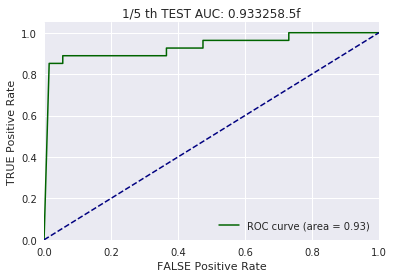

====== [6 to 11) ====== 2/5 th Learning ================
class weight: [0.5293953 9.0047619]
421/421 [==============================] - 0s 133us/step
Test tf AUC:  0.9178381757611617
(TN: 392,FP: 4, FN: 7, TP: 18)
False Positive Rate: 0.01010
False Negative Rate: 0.28000
AUC: 0.93381


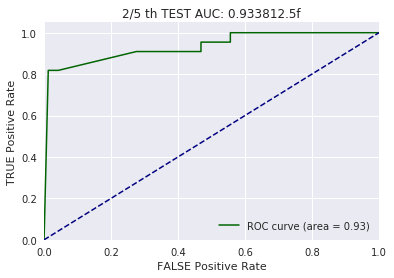

====== [6 to 11) ====== 3/5 th Learning ================
class weight: [0.52895105 9.1352657 ]
421/421 [==============================] - 0s 110us/step
Test tf AUC:  0.8899577310985738
(TN: 376,FP: 2, FN: 20, TP: 23)
False Positive Rate: 0.00529
False Negative Rate: 0.46512
AUC: 0.97505


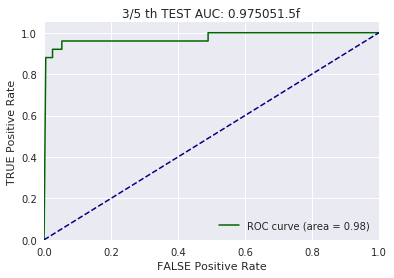

====== [6 to 11) ====== 4/5 th Learning ================
class weight: [0.52895105 9.1352657 ]
421/421 [==============================] - 0s 116us/step
Test tf AUC:  0.923653417131963
(TN: 391,FP: 4, FN: 5, TP: 21)
False Positive Rate: 0.01013
False Negative Rate: 0.19231
AUC: 0.91121


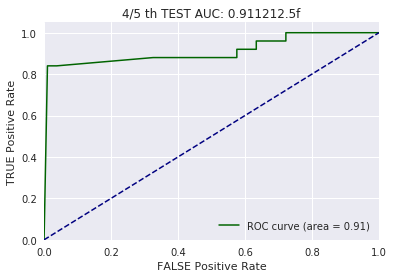

====== [6 to 11) ====== 5/5 th Learning ================
class weight: [0.52998879 8.8364486 ]
421/421 [==============================] - 0s 114us/step
Test tf AUC:  0.9043080680727109
(TN: 394,FP: 3, FN: 9, TP: 15)
False Positive Rate: 0.00756
False Negative Rate: 0.37500
AUC: 0.94210


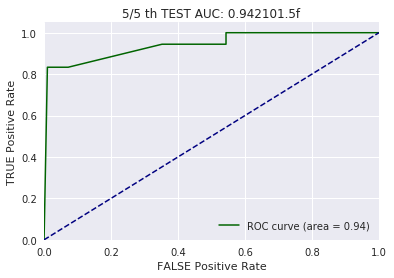

====== [6 to 11) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.93909 (+/- 0.0207)
False Positive Rate: 0.00867 (+/- 0.0020)
False Negative Rate: 0.31410 (+/- 0.0956)
Xy shape: (8198, 101)
====== [11 to 16) ====== 1/5 th Learning ================
class weight: [0.54953076 5.54736842]
820/820 [==============================] - 0s 122us/step
Test tf AUC:  0.9570582927727118
(TN: 728,FP: 6, FN: 21, TP: 65)
False Positive Rate: 0.00817
False Negative Rate: 0.24419
AUC: 0.97502


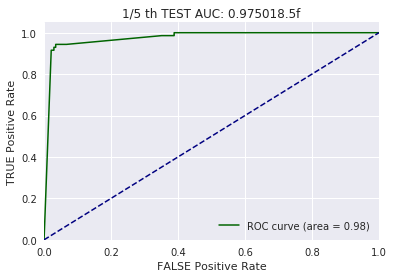

====== [11 to 16) ====== 2/5 th Learning ================
class weight: [0.55067921 5.43298969]
820/820 [==============================] - 0s 119us/step
Test tf AUC:  0.9520863722010356
(TN: 742,FP: 3, FN: 21, TP: 54)
False Positive Rate: 0.00403
False Negative Rate: 0.28000
AUC: 0.97158


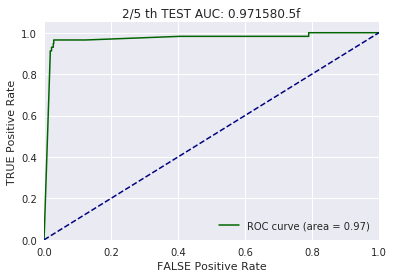

====== [11 to 16) ====== 3/5 th Learning ================
class weight: [0.54912176 5.58939394]
820/820 [==============================] - 0s 120us/step
Test tf AUC:  0.9458848828222693
(TN: 734,FP: 10, FN: 10, TP: 66)
False Positive Rate: 0.01344
False Negative Rate: 0.13158
AUC: 0.95708


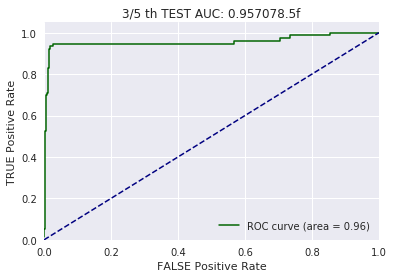

====== [11 to 16) ====== 4/5 th Learning ================
class weight: [0.54920351 5.58093797]
820/820 [==============================] - 0s 120us/step
Test tf AUC:  0.3817087701181086
(TN: 745,FP: 75, FN: 0, TP: 0)
False Positive Rate: 0.09146
False Negative Rate: 0.00000
AUC: 0.07475


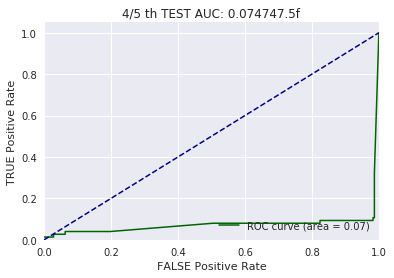

====== [11 to 16) ====== 5/5 th Learning ================
class weight: [0.55051485 5.44903988]
820/820 [==============================] - 0s 118us/step
Test tf AUC:  0.37289093209476004
(TN: 760,FP: 59, FN: 1, TP: 0)
False Positive Rate: 0.07204
False Negative Rate: 0.99990
AUC: 0.04155


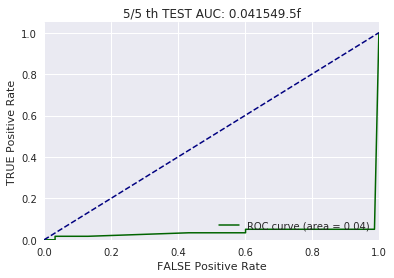

====== [11 to 16) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.60399 (+/- 0.4458)
False Positive Rate: 0.03783 (+/- 0.0365)
False Negative Rate: 0.33113 (+/- 0.3484)
Xy shape: (11879, 101)
====== [16 to 21) ====== 1/5 th Learning ================
class weight: [0.54368389 6.22293364]
1188/1188 [==============================] - 0s 130us/step
Test tf AUC:  0.9197364116357232
(TN: 1097,FP: 18, FN: 14, TP: 59)
False Positive Rate: 0.01614
False Negative Rate: 0.19178
AUC: 0.96656


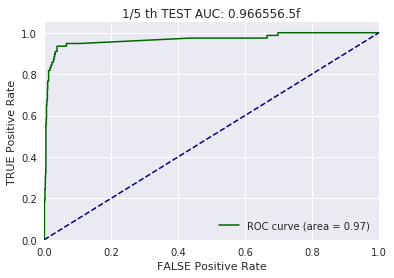

====== [16 to 21) ====== 2/5 th Learning ================
class weight: [0.54313148 6.29623086]
1188/1188 [==============================] - 0s 159us/step
Test tf AUC:  0.9297869887817588
(TN: 1096,FP: 69, FN: 5, TP: 18)
False Positive Rate: 0.05923
False Negative Rate: 0.21739
AUC: 0.96230


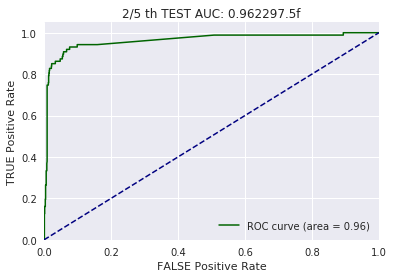

====== [16 to 21) ====== 3/5 th Learning ================
class weight: [0.54192011 6.4637243 ]
1188/1188 [==============================] - 0s 151us/step
Test tf AUC:  0.9328663682295417
(TN: 1051,FP: 18, FN: 28, TP: 91)
False Positive Rate: 0.01684
False Negative Rate: 0.23529
AUC: 0.93566


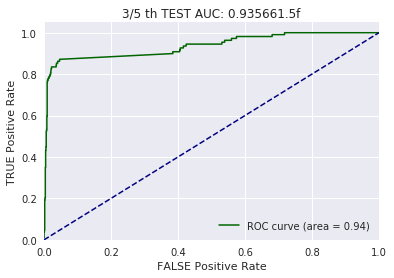

====== [16 to 21) ====== 4/5 th Learning ================
class weight: [0.54285569 6.33353081]
1188/1188 [==============================] - 0s 129us/step
Test tf AUC:  0.36684041633349074
(TN: 1096,FP: 92, FN: 0, TP: 0)
False Positive Rate: 0.07744
False Negative Rate: 0.00000
AUC: 0.10221


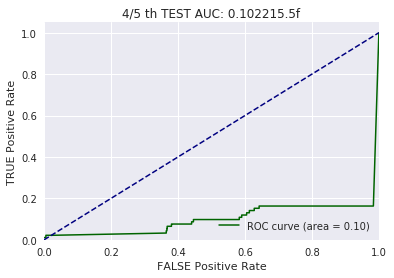

====== [16 to 21) ====== 5/5 th Learning ================
class weight: [0.54329708 6.27406103]
1188/1188 [==============================] - 0s 145us/step
Test tf AUC:  0.923858004788357
(TN: 1100,FP: 84, FN: 4, TP: 0)
False Positive Rate: 0.07095
False Negative Rate: 0.99998
AUC: 0.93817


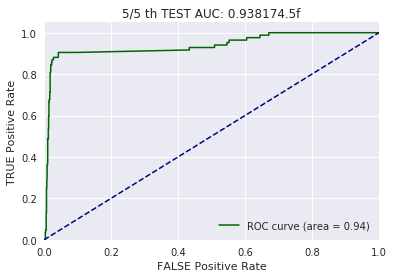

====== [16 to 21) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.78098 (+/- 0.3396)
False Positive Rate: 0.04812 (+/- 0.0265)
False Negative Rate: 0.32889 (+/- 0.3460)
Xy shape: (28717, 101)
====== [21 to 26) ====== 1/5 th Learning ================
class weight: [ 0.51752103 14.76857143]
2872/2872 [==============================] - 0s 143us/step
Test tf AUC:  0.7091151978976216
(TN: 2775,FP: 89, FN: 4, TP: 4)
False Positive Rate: 0.03108
False Negative Rate: 0.49999
AUC: 0.87739


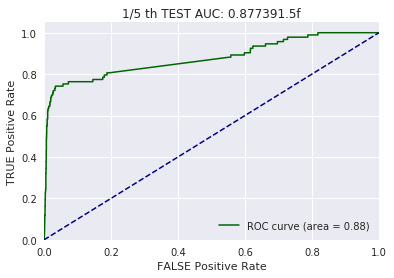

====== [21 to 26) ====== 2/5 th Learning ================
class weight: [ 0.51762467 14.68465909]
2872/2872 [==============================] - 0s 125us/step
Test tf AUC:  0.9086478261230384
(TN: 1194,FP: 72, FN: 1590, TP: 16)
False Positive Rate: 0.05687
False Negative Rate: 0.99004
AUC: 0.45083


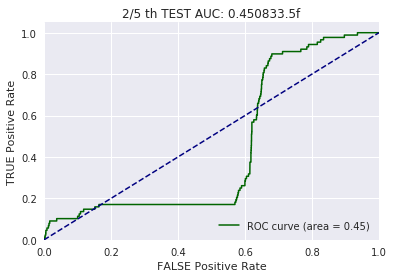

====== [21 to 26) ====== 3/5 th Learning ================
class weight: [ 0.51716893 15.06118881]
2872/2872 [==============================] - 0s 158us/step
Test tf AUC:  0.6450124932530863
(TN: 2743,FP: 37, FN: 19, TP: 73)
False Positive Rate: 0.01331
False Negative Rate: 0.20652
AUC: 0.88927


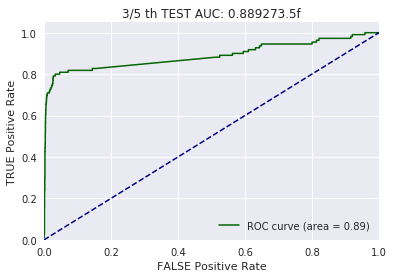

====== [21 to 26) ====== 4/5 th Learning ================
class weight: [ 0.51758321 14.71810934]
2872/2872 [==============================] - 0s 132us/step
Test tf AUC:  0.47949229666449567
(TN: 2777,FP: 89, FN: 5, TP: 1)
False Positive Rate: 0.03105
False Negative Rate: 0.83332
AUC: 0.17181


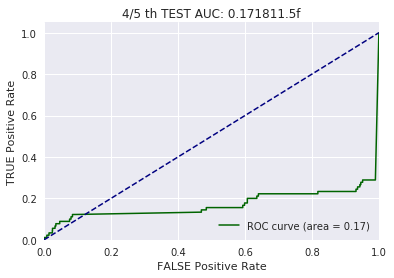

====== [21 to 26) ====== 5/5 th Learning ================
class weight: [ 0.51772837 14.60169492]
2872/2872 [==============================] - 0s 136us/step
Test tf AUC:  0.4235142613021776
(TN: 2789,FP: 81, FN: 0, TP: 2)
False Positive Rate: 0.02822
False Negative Rate: 0.00000
AUC: 0.20400


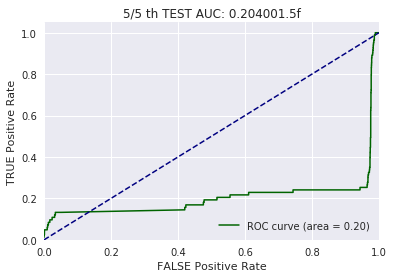

====== [21 to 26) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.51866 (+/- 0.3130)
False Positive Rate: 0.03211 (+/- 0.0140)
False Negative Rate: 0.50597 (+/- 0.3707)
Xy shape: (64654, 101)
====== [26 to 31) ====== 1/5 th Learning ================
class weight: [ 0.51495628 17.21538462]
6466/6466 [==============================] - 1s 183us/step
Test tf AUC:  0.6871569857964602
(TN: 6226,FP: 55, FN: 57, TP: 128)
False Positive Rate: 0.00876
False Negative Rate: 0.30811
AUC: 0.88434


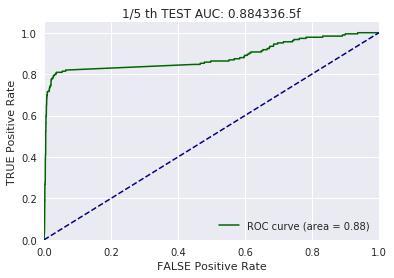

====== [26 to 31) ====== 2/5 th Learning ================
class weight: [ 0.51475584 17.44244604]
6466/6466 [==============================] - 1s 160us/step
Test tf AUC:  0.878464516732776
(TN: 6260,FP: 196, FN: 1, TP: 9)
False Positive Rate: 0.03036
False Negative Rate: 0.10000
AUC: 0.89376


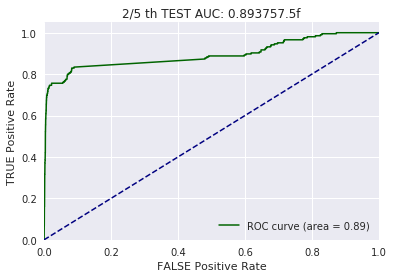

====== [26 to 31) ====== 3/5 th Learning ================
class weight: [ 0.51506568 17.09400705]
6466/6466 [==============================] - 1s 162us/step
Test tf AUC:  0.8114785525660894
(TN: 6265,FP: 74, FN: 30, TP: 97)
False Positive Rate: 0.01167
False Negative Rate: 0.23622
AUC: 0.92010


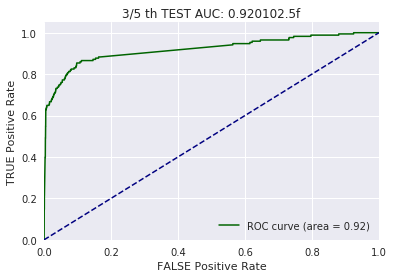

====== [26 to 31) ====== 4/5 th Learning ================
class weight: [ 0.51476495 17.43199521]
6466/6466 [==============================] - 1s 165us/step
Test tf AUC:  0.9084872598254271
(TN: 6236,FP: 90, FN: 26, TP: 114)
False Positive Rate: 0.01423
False Negative Rate: 0.18571
AUC: 0.93155


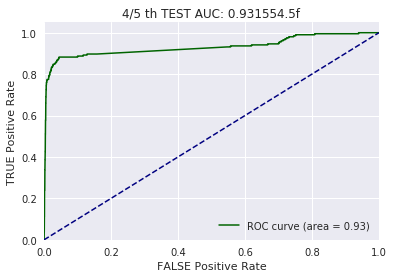

====== [26 to 31) ====== 5/5 th Learning ================
class weight: [ 0.51482871 17.35918854]
6466/6466 [==============================] - 1s 130us/step
Test tf AUC:  0.902618651636385
(TN: 6201,FP: 46, FN: 68, TP: 151)
False Positive Rate: 0.00736
False Negative Rate: 0.31050
AUC: 0.92488


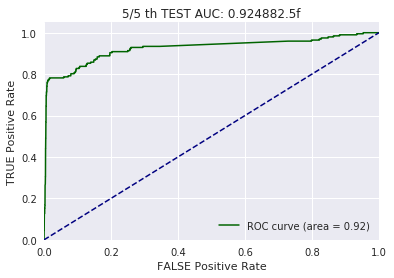

====== [26 to 31) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.91093 (+/- 0.0185)
False Positive Rate: 0.01448 (+/- 0.0083)
False Negative Rate: 0.22811 (+/- 0.0793)
Xy shape: (233880, 101)
====== [31 to 36) ====== 1/5 th Learning ================
class weight: [ 0.51710059 15.1193794 ]
23388/23388 [==============================] - 4s 161us/step
Test tf AUC:  0.9287210879966868
(TN: 22540,FP: 276, FN: 140, TP: 432)
False Positive Rate: 0.01210
False Negative Rate: 0.24476
AUC: 0.88790


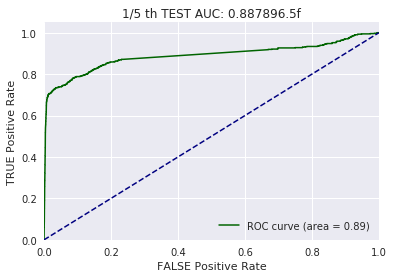

====== [31 to 36) ====== 2/5 th Learning ================
class weight: [ 0.51698629 15.21775593]
23388/23388 [==============================] - 5s 194us/step
Test tf AUC:  0.9317183912728043
(TN: 22392,FP: 261, FN: 243, TP: 492)
False Positive Rate: 0.01152
False Negative Rate: 0.33061
AUC: 0.90673


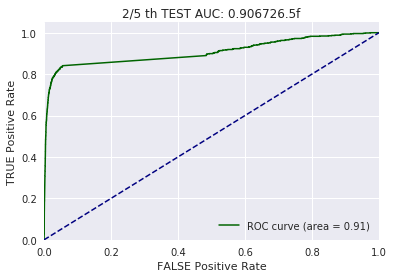

====== [31 to 36) ====== 3/5 th Learning ================
class weight: [ 0.51689996 15.2929381 ]
23388/23388 [==============================] - 5s 224us/step
Test tf AUC:  0.9313800674698303
(TN: 22456,FP: 260, FN: 145, TP: 527)
False Positive Rate: 0.01145
False Negative Rate: 0.21577
AUC: 0.91799


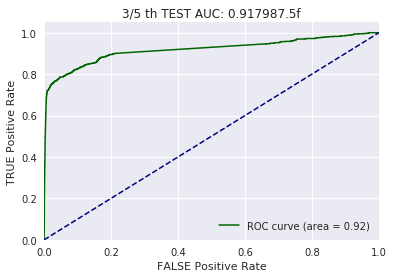

====== [31 to 36) ====== 4/5 th Learning ================
class weight: [ 0.51699136 15.21335646]
23388/23388 [==============================] - 4s 191us/step
Test tf AUC:  0.9288246179312055
(TN: 22487,FP: 231, FN: 150, TP: 520)
False Positive Rate: 0.01017
False Negative Rate: 0.22388
AUC: 0.94374


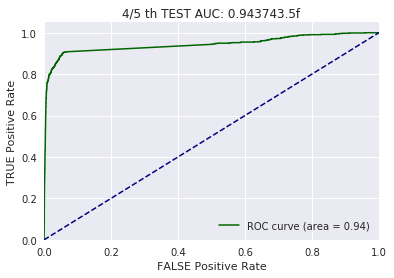

====== [31 to 36) ====== 5/5 th Learning ================
class weight: [ 0.5169939  15.21115768]
23388/23388 [==============================] - 5s 198us/step
Test tf AUC:  0.9322094950326104
(TN: 22487,FP: 261, FN: 151, TP: 489)
False Positive Rate: 0.01147
False Negative Rate: 0.23594
AUC: 0.94129


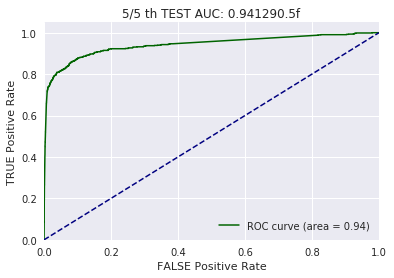

====== [31 to 36) ========== Result ================
OVERALL TEST AUC Sk-learn: 0.91953 (+/- 0.0211)
False Positive Rate: 0.01134 (+/- 0.0006)
False Negative Rate: 0.25019 (+/- 0.0414)


In [25]:
from sklearn.linear_model import LogisticRegression


length_interval = 5
for start in range(1,36,length_interval):
    Xy = get_range_of_customers(dict_dfs, start, start+length_interval)
    print('Xy shape:',Xy.shape)
    raw_data = Xy[:,3:-1]
    labels = Xy[:,-1]
    
    auc_sk_list = []
    fn_rate_list = []
    fp_rate_list = []
    num_of_folds = 5 ## k of k-fold cv ##
    for k_index in range(num_of_folds):
        print('====== [%d to %d) ====== %d/%d th Learning ================'%(start,start+length_interval,k_index+1,num_of_folds))
        X_train , X_test , y_train , y_test = train_test_split(raw_data , labels , test_size = 0.1,shuffle=True)
        
        y_train =y_train.astype('int')
        y_test = y_test.astype('int')

        M = X_train.shape[1]
        my_class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

        print('class weight:',my_class_weight)
        
        model = keras.Sequential()
        model.add(keras.layers.Dense(M, input_dim=M, kernel_initializer='normal', activation='sigmoid'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(M//2, kernel_initializer='normal', activation='relu'))
        model.add(keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[AUC])

        model.fit(X_train, y_train, epochs=25, class_weight = my_class_weight,verbose=0)
        train_loss, train_auc = model.evaluate(X_train, y_train)
        test_loss, test_auc = model.evaluate(X_test, y_test)
        print('Test tf AUC: ',test_auc)
        auc_list.append(test_auc)

        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(np.where(y_pred > 0.5, 1, 0), y_test).ravel()

        fp_rate = float(fp)/float(fp+tn+0.0001)
        fn_rate = float(fn)/float(tp+fn+0.0001)
        fp_rate_list.append(fp_rate)
        fn_rate_list.append(fn_rate)
        print('(TN: %d,FP: %d, FN: %d, TP: %d)'%(tn,fp,fn,tp))
        print('False Positive Rate: %.5f'%(fp_rate))
        print('False Negative Rate: %.5f'%(fn_rate))

        fpr, tpr, th = roc_curve(y_test, y_pred)
        auc_sk = auc(fpr, tpr)
        auc_sk_list.append(auc_sk)
        print('AUC: %.5f'%(auc_sk))

        plt.figure()
        plt.title('%d/%d th TEST AUC: %f.5f'%(k_index+1,num_of_folds,auc_sk))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('FALSE Positive Rate')
        plt.ylabel('TRUE Positive Rate')
        plt.plot(fpr, tpr, color=LC,lw=LW, label='ROC curve (area = %0.2f)' % auc_sk)
        plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') # reference line for random classifier
        plt.legend(loc=LL)
        plt.show()
    
    print('====================================================')
    print('====== [%d to %d) ========== Result ================'%(start,start+length_interval))
    temp = np.mean(auc_sk_list)
    print('OVERALL TEST AUC Sk-learn: %.5f (+/- %.4f)'%(temp,np.std(auc_sk_list)))
    print('False Positive Rate: %.5f (+/- %.4f)'%(np.mean(fp_rate_list),np.std(fp_rate_list)))
    print('False Negative Rate: %.5f (+/- %.4f)'%(np.mean(fn_rate_list),np.std(fn_rate_list)))
    print('====================================================')
    
